In [1]:
import os
import sys
from pyspark.sql import SparkSession

# Use current virtualenv's Python
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("test") \
    .getOrCreate()

# dummy input
data = [{"id": 1, "name": "Alice"}, {"id": 2, "name": "Bob"}]
dfs = spark.createDataFrame(data)
dfs.show(5)

+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



In [2]:
# Import data
import pandas as pd

interaction_df = pd.read_csv('goodreads_interactions.csv')

interaction_df_clean = interaction_df[['user_id', 'book_id', 'rating']][interaction_df['is_read'] == 1]

# Group by user_id and count unique book_ids
books_per_user = interaction_df_clean.groupby('user_id')['book_id'].nunique()

#Compute the 99th percentile
threshold = books_per_user.quantile(0.95)

# Step 3: Identify users at or below the threshold
valid_users = books_per_user[books_per_user <= threshold].index



# from collections import defaultdict

# user_items = filtered_df.groupby('user_id')['book_id'].apply(set).to_dict()


In [3]:
# Step 4: Filter the original dataframe
filtered_df = interaction_df_clean[interaction_df_clean['user_id'].isin(valid_users)].sample(n=1000000, random_state=42)
filtered_df.head()

,user_id,book_id,rating
181699697,382396,36143,2
172956448,361287,8434,3
16101228,31603,56353,4
1419438,2798,377527,5
213221926,464725,485419,5


In [ ]:
import os
import sys
# os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 14g pyspark-shell"
# Force Spark to use the current python interpreter!
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession

# initiate a new spark session
# spark = SparkSession.builder.appName(name='GoodReadALS').getOrCreate()
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("test") \
    .getOrCreate()

# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")



In [5]:
# create spark dataframe 

dfs = spark.createDataFrame(filtered_df)

In [6]:
# # show first 5 rows of spark dataframe
dfs.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
| 382396|  36143|     2|
| 361287|   8434|     3|
|  31603|  56353|     4|
|   2798| 377527|     5|
| 464725| 485419|     5|
+-------+-------+------+
only showing top 5 rows


In [7]:
# rename cols as spark accepst 'user' & 'movie' col names
dfs = dfs.withColumnsRenamed({
    'user_id': 'user',
    'book_id': 'book',
})

# split data in train & test sets 
dfs_train, dfs_test = dfs.randomSplit([0.8, 0.2], 42)

In [ ]:
# # import ALS model from spark
# from pyspark.ml.recommendation import ALS

# # initialise the model 
# als = ALS(maxIter=10, regParam=0.1, rank=10, userCol="user", itemCol="book", 
#           ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

# # train model 
# als_model = als.fit(dfs_train)

In [ ]:
# # generate predictions
# dfs_preds = als_model.transform(dfs_test)

# # show preds dataframe
# dfs_preds.show(5)

In [ ]:
# from pyspark.ml.evaluation import RegressionEvaluator

# # initiate evaluator
# eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
# # calculate rmse
# rmse = eval.evaluate(dfs_preds)

# # reset metric and evaluate mse, R2, mae & explained variance
# r2 = eval.evaluate(dfs_preds, {eval.metricName: 'r2'})
# mae = eval.evaluate(dfs_preds, {eval.metricName: 'mae'})
# var = eval.evaluate(dfs_preds, {eval.metricName: 'var'})


# print(
#     "RMSE score = {}".format(rmse),
#     "R2 score = {}".format(r2),
#     "MAE score = {}".format(mae),
#     "Explained variance score = {}".format(var),
#     sep="\n"
# )

In [8]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# initiate model without hyperparams
# initialise the model
als = ALS(userCol="user", itemCol="book", ratingCol="rating", 
          coldStartStrategy="drop", nonnegative=True)

# create a hyperparameter grid
param_grid = ParamGridBuilder().addGrid(
    als.rank, [10]
    ).addGrid(
        als.maxIter, [10]
    ).addGrid(
        als.regParam, [0.05]
    ).build()

# create an evaluation metric
eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# use cross validator to run models
cv = CrossValidator(
    estimator=als, 
    estimatorParamMaps=param_grid,
    evaluator=eval,
    numFolds=3
)

als_model = cv.fit(dfs_train)

# get rmse scores from trained model
rmse_scores = als_model.avgMetrics
# get params map
param_maps = als_model.getEstimatorParamMaps()

model_acc = []
# iterate using zip 
for param_map, rmse in zip(param_maps, rmse_scores): 
  params = {param.name: value for param, value in param_map.items()}
  params['rmse'] = rmse
  model_acc.append(params)

# convert model_acc data into a pandas DataFrame
df_acc = pd.DataFrame(model_acc)

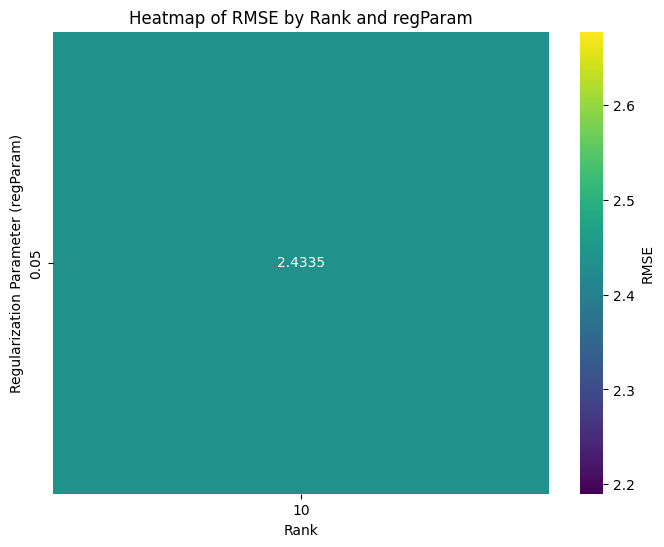

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# Pivot the DataFrame to create a grid for heatmap
heatmap_data = df_acc.pivot(index='regParam', columns='rank', values='rmse')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'RMSE'})
plt.title('Heatmap of RMSE by Rank and regParam')
plt.xlabel('Rank')
plt.ylabel('Regularization Parameter (regParam)')
plt.show()

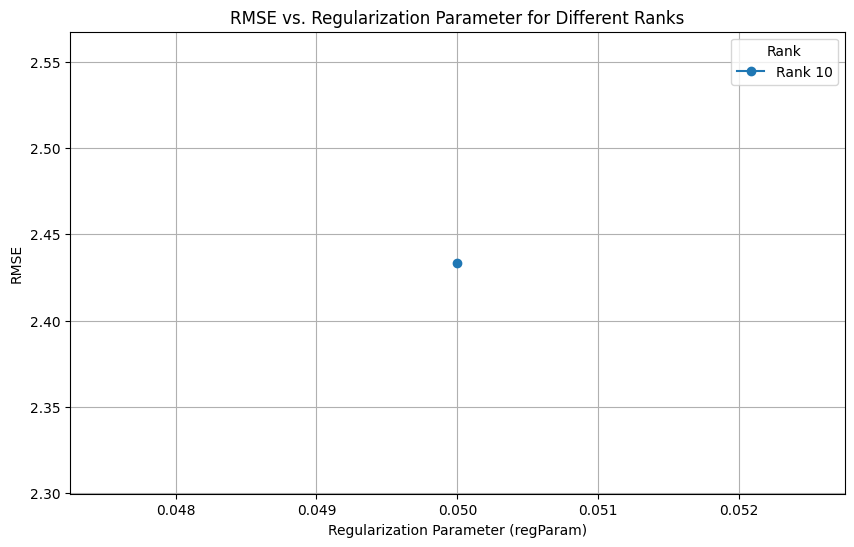

In [11]:
# Create a line plot for each rank
plt.figure(figsize=(10, 6))

for rank in sorted(set(d['rank'] for d in model_acc)):
    rank_data = [d for d in model_acc if d['rank'] == rank]
    reg_params = [d['regParam'] for d in rank_data]
    rmses = [d['rmse'] for d in rank_data]
    plt.plot(reg_params, rmses, marker='o', label=f'Rank {rank}')

# Add labels and legend
plt.title('RMSE vs. Regularization Parameter for Different Ranks')
plt.xlabel('Regularization Parameter (regParam)')
plt.ylabel('RMSE')
plt.legend(title='Rank')
plt.grid(True)
plt.show()

In [12]:
best_model = als_model.bestModel

In [13]:
# Save the trained ALS model

best_model.write().overwrite().save("als_model")


In [14]:
user_recs = best_model.recommendForAllUsers(5)
user_recs.show(truncate=False)

+----+-------------------------------------------------------------------------------------------------------------+
|user|recommendations                                                                                              |
+----+-------------------------------------------------------------------------------------------------------------+
|31  |[{1126716, 10.136458}, {673714, 10.1066475}, {623298, 10.0788355}, {2031215, 9.7910385}, {1896861, 9.786571}]|
|34  |[{1978586, 11.345668}, {473851, 11.340048}, {247831, 11.071041}, {270664, 10.904728}, {1802412, 10.785442}]  |
|65  |[{552748, 12.800273}, {272451, 11.839228}, {2011455, 11.7571}, {1518805, 11.35747}, {567221, 11.3473425}]    |
|78  |[{236394, 7.8244023}, {258546, 7.5359926}, {174141, 7.5359926}, {702409, 7.3347144}, {1715742, 7.265935}]    |
|85  |[{1487959, 12.805325}, {1746863, 12.534154}, {151125, 12.1825485}, {617178, 12.06793}, {387672, 12.050993}]  |
|108 |[{1589880, 0.0}, {1589380, 0.0}, {1588790, 0.0}, {1588730,

In [15]:
from pyspark.sql.functions import explode, col

flat_recs = user_recs.select(
    col("user"),
    explode("recommendations").alias("rec")
).select(
    col("user"),
    col("rec.book").alias("book"),
    col("rec.rating").alias("rating")
)

In [16]:
(
    flat_recs
    .coalesce(1)                       # <-- only 1 output partition
    .write
    .mode("overwrite")
    .option("header", True)
    .csv("user_recs_tmp")              # create a temp folder
)

# --- Rename the single part-file to something nice ---------------------------
import os, glob, shutil, pathlib

tmp_dir = pathlib.Path("user_recs_tmp")
part_file = glob.glob(str(tmp_dir / "part-*.csv"))[0]   # first/only part file
shutil.move(part_file, "user_recommendations.csv")      # final filename
shutil.rmtree(tmp_dir) 